In [2]:
import uproot, pylhe, glob, os
import numpy as np
import numba,vector
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 

In [3]:
lhe_signal=glob.glob("/localscratch/Samples/Signal/SM/WWW01j_000[0-4].lhe.gz")
root_signal=glob.glob("/localscratch/Samples/Signal/SM/WWW01j_000[0-4].root")

lhe_bkg=glob.glob("/localscratch/Samples/3l01j/3l01j_00[0-1]?.lhe.gz")
root_bkg=glob.glob("/localscratch/Samples/3l01j/3l01j_00[0-1]?.root")

In [4]:
def get_xSection(lhefiles):
    init=pylhe.read_lhe_init(lhefiles[0])

    xSection=0.
    for process in init['procInfo']:
        xSection+=process['xSection']
    return xSection # in pb

In [5]:
def getNeventsLHE(lhefiles):
    N=0
    for f in lhefiles:
        lines=os.popen('zgrep "</event>" '+f+"|wc -l").readlines()
        N+=int(lines[0])
    return N

In [6]:
xSection_sig=get_xSection(lhe_signal)
xSection_bkg=get_xSection(lhe_bkg)
print(xSection_sig,xSection_bkg)

0.017245120000000003 0.8901096


In [7]:
N_lhe_sig=1000000 #getNeventsLHE(lhe_signal)
N_lhe_bkg=4000000 #getNeventsLHE(lhe_bkg)
print(N_lhe_sig,N_lhe_bkg)

1000000 4000000


In [8]:
def getNeventsRoot(rootfiles):
    N=0
    for f in rootfiles:
        with uproot.open(f+':Delphes') as tree:
            N+=tree.num_entries
    return N

In [9]:
N_root_sig=511723 #getNeventsRoot(root_signal)
N_root_bgk=2964674 #getNeventsRoot(root_bkg)
print(N_root_sig,N_root_bgk)

511723 2964674


In [10]:
#calculate resulting xSection*efficiency
xSection_sig*=N_root_sig/N_lhe_sig
xSection_bkg*=N_root_bgk/N_lhe_bkg
print(xSection_sig,xSection_bkg)

0.008824724541760002 0.6597211970676


In [12]:
#show available branches
tree=uproot.open(root_signal[0]+':Delphes')
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Event                | int32_t                  | AsDtype('>i4')
Event/Event.fUniq... | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.fBits    | uint32_t[]               | AsJagged(AsDtype('>u4'))
Event/Event.Number   | int64_t[]                | AsJagged(AsDtype('>i8'))
Event/Event.ReadTime | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.ProcTime | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Proce... | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.MPI      | int32_t[]                | AsJagged(AsDtype('>i4'))
Event/Event.Weight   | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Cross... | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Cross... | float[]                  | AsJagged(AsDtype('>f4'))
Event/Event.Scale    | 

In [13]:
#show only specifc elements
tree['MissingET'].show(filter_name="MissingET.*")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
MissingET            | int32_t                  | AsDtype('>i4')                
MissingET.fUniqueID  | uint32_t[]               | AsJagged(AsDtype('>u4'))
MissingET.fBits      | uint32_t[]               | AsJagged(AsDtype('>u4'))
MissingET.MET        | float[]                  | AsJagged(AsDtype('>f4'))
MissingET.Eta        | float[]                  | AsJagged(AsDtype('>f4'))
MissingET.Phi        | float[]                  | AsJagged(AsDtype('>f4'))


In [14]:

tree['Electron'].show(filter_name="Electron.*", name_width=40)

name                                     | typename                 | interpretation                
-----------------------------------------+--------------------------+-------------------------------
Electron                                 | int32_t                  | AsDtype('>i4')                
Electron.fUniqueID                       | uint32_t[]               | AsJagged(AsDtype('>u4'))
Electron.fBits                           | uint32_t[]               | AsJagged(AsDtype('>u4'))
Electron.PT                              | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Eta                             | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Phi                             | float[]                  | AsJagged(AsDtype('>f4'))
Electron.T                               | float[]                  | AsJagged(AsDtype('>f4'))
Electron.Charge                          | int32_t[]                | AsJagged(AsDtype('>i4'))
Electron.EhadOverEem            

In [15]:
#specify the variables we are interested in
tree.keys(filter_name="/(MissingET.(MET|Phi)|Particle.(PID|Status)|Electron.(PT|Eta|Phi)|"
          "Muon.(PT|Eta|Phi)|Jet.(PT|Eta|Phi))/")

['Particle/Particle.PID',
 'Particle/Particle.Status',
 'Jet/Jet.PT',
 'Jet/Jet.Eta',
 'Jet/Jet.Phi',
 'Jet/Jet.PTD',
 'Electron/Electron.PT',
 'Electron/Electron.Eta',
 'Electron/Electron.Phi',
 'Muon/Muon.PT',
 'Muon/Muon.Eta',
 'Muon/Muon.Phi',
 'MissingET/MissingET.MET',
 'MissingET/MissingET.Phi']

In [11]:
@numba.jit(nopython=True)
def checkHiggs(batch):
    higgs=np.full((len(batch),),False)
    for i in range(len(batch)):
        for p in range(len(batch[i]['Particle.PID'])):
            if abs(batch[i]['Particle.PID'][p])==25:
                higgs[i]=True
                break
    return higgs

In [12]:
@numba.jit(nopython=True)
def get_MET(batch):
    met=np.zeros((len(batch),))
    metPhi=np.zeros((len(batch),))
    for i in range(len(batch)):
        met[i]=float(batch[i]['MissingET.MET'][0])
        metPhi[i]=float(batch[i]['MissingET.Phi'][0])
    return met, metPhi

In [42]:
@numba.jit(nopython=True)
def get_minDRll(batch):
    DRll=np.full((len(batch),),1000.)
    for i in range(len(batch)):
        leptons=[]

        #loop over electrons
        for e in range(len(batch[i]['Electron.PT'])):
            leptons.append(vector.obj(pt=batch[i]['Electron.PT'][e], 
                                      phi=batch[i]['Electron.Phi'][e], 
                                      eta=batch[i]['Electron.Eta'][e], 
                                      mass=511./1e6))
        #loop over muons
        for m in range(len(batch[i]['Muon.PT'])):
            leptons.append(vector.obj(pt=batch[i]['Muon.PT'][m], 
                                      phi=batch[i]['Muon.Phi'][m], 
                                      eta=batch[i]['Muon.Eta'][m], 
                                      mass=105.66/1e3)) # in GeV
        mindr=DRll[i]
        for l1 in leptons:
            for l2 in leptons:
                if l1==l2:
                    continue
                if l1.deltaR(l2)<mindr:
                    mindr=l1.deltaR(l2)

        met, metPhi = get_MET(batch)
        #METvec = vector.obj(E=met, phi=metPhi)

        for l1 in leptons:
            for l2 in leptons:
                if l1==l2:
                    pass
                else:
                    for l0 in leptons:
                        if l0 == l1:
                            pass
                        elif l0 == l2:
                            pass
                        else:
                            PT_l0 = l0.p
                            PT_l1 = l1.p
                            PT_l2 = l2.p

                            #deltaPhi_l0_MET = l1.deltaangle(METvec)
                           # deltaPhi_l1_MET = l1.deltaangle(METvec)
                            #deltaPhi_l2_MET = l2.deltaangle(METvec)
                            
                            invarM_l0l2=(l0.p2+l2.p2)**2
                            invarM_l1l2=(l1.p2+l2.p2)**2
                            invarM_l0l1=(l0.p2+l1.p2)**2

                            invarM=(l1.p2+l2.p2+l0.p2)**2
                            
                            E_l1l2=np.sqrt((l1.p+l2.p)**2 + invarM_l1l2)
                            E_l0l2=np.sqrt((l0.p+l2.p)**2 + invarM_l0l2)
                            E_l0l1=np.sqrt((l0.p+l1.p)**2 + invarM_l0l1)
                            transM_l1l2=np.sqrt((E_l1l2+batch[i]['MissingET.MET'][0])**2 - np.abs(l1.p * l2.p + batch[i]['MissingET.MET'][0])**2)
                            transM_l0l2=np.sqrt((E_l0l2+batch[i]['MissingET.MET'][0])**2 - np.abs(l0.p * l2.p + batch[i]['MissingET.MET'][0])**2)
                            transM_l0l1=np.sqrt((E_l0l1+batch[i]['MissingET.MET'][0])**2 - np.abs(l0.p * l1.p + batch[i]['MissingET.MET'][0])**2)
                            
                            deltaeta_l1l2=l1.deltaeta(l2)
                            deltaeta_l0l2=l0.deltaeta(l2)
                            deltaeta_l0l1=l0.deltaeta(l1)
                            
                            deltaangle_l1l2=l1.deltaangle(l2)
                            deltaangle_l0l2=l0.deltaangle(l2)
                            deltaangle_l0l1=l0.deltaangle(l1) 

                            dR_l1l2 = l1.deltaR(l2)
                            dR_l0l1 = l0.deltaR(l1)
                            dR_l0l2 = l0.deltaR(l2)

                            totalP = l0.p + l1.p + l2.p 
        
    DRll[i]=mindr
    dataset = {'Number Leptons Produced': len(leptons), 'PT_l0': PT_l0, 'PT_l1': PT_l1, 'PT_l2': PT_l2, 
               'MET': met, 'MET_Phi': metPhi, 
               'm_l0l1': invarM_l0l1, 'm_l0l2': invarM_l0l2, 'm_l1l2': invarM_l1l2, 'm_lll': invarM,
               'mT_l0l1': transM_l0l1, 'mT_l0l2': transM_l0l2, 'mT_l1l2': transM_l1l2, 
               'delEta_l0l1': deltaeta_l0l1, 'delEta_l0l2': deltaeta_l0l2, 'delEta_l1l2': deltaeta_l1l2,
              'delPhi_l0l1': deltaangle_l0l1, 'delPhi_l0l2': deltaangle_l0l2, 'delPhi_l1l2': deltaangle_l1l2,
              'delR_l0l1': dR_l0l1, 'delR_l0l2': dR_l0l2, 'delR_l1l2': dR_l1l2, 
               'DRll': DRll, 'sumPT': totalP}
    print(dataset)

    return dataset

In [18]:
@numba.jit(nopython=True)
def preselection(batch):
    pass_selection=np.full((len(batch),),False)
    for i in range(len(batch)):
        nElectrons=0
        nMuons=0
        nJets=0

        for e in range(len(batch[i]['Electron.PT'])):
            if batch[i]['Electron.PT'][e]>=10.0 and abs(batch[i]['Electron.Eta'][e])<2.5:
                nElectrons+=1


        for m in range(len(batch[i]['Muon.PT'])):
            if batch[i]['Muon.PT'][m]>=10.0 and abs(batch[i]['Muon.Eta'][m])<2.5:
                nMuons+=1

        for j in range(len(batch[i]['Jet.PT'])):
            if batch[i]['Jet.PT'][j]>=25.0 and abs(batch[i]['Jet.Eta'][j])<2.5:
                nJets+=1

        if nElectrons+nMuons==3 and nJets<5:
            pass_selection[i]=True

    return pass_selection
    

In [15]:
def batch_automator(batch):
    for batch in tqdm(iterator, total=N_root_sig//batch_size):
        higgs=checkHiggs(batch)
        met, metPhi=get_MET(batch)
        dr =get_minDRll(batch)
        print(dr)
        presel=preselection(batch)
        if met_VH is not None:
                met_VH=np.concatenate((met_VH,met[np.logical_and(higgs,presel)]),axis=0)
                met_WWW=np.concatenate((met_WWW,met[np.logical_and(~higgs,presel)]),axis=0)

                dr_VH=np.concatenate((dr_VH,dr[np.logical_and(higgs,presel)]),axis=0)
                dr_WWW=np.concatenate((dr_WWW,dr[np.logical_and(~higgs,presel)]),axis=0)

                #invarM_VH=np.concatenate((dr_VH,dr[np.logical_and(higgs,presel)]),axis=0)
               # invarM_WWW=np.concatenate((dr_VH,dr[np.logical_and(higgs,presel)]),axis=0)
        else:
                met_VH=np.array(met[np.logical_and(higgs,presel)])
                met_WWW=np.array(met[np.logical_and(~higgs,presel)])

                dr_VH=np.array(dr[np.logical_and(higgs,presel)])
                dr_WWW=np.array(dr[np.logical_and(~higgs,presel)])

              # invarM_VH=np.array(dr[np.logical_and(higgs,presel)])
              #  invarM_WWW=np.array(dr[np.logical_and(~higgs,presel)])

IndentationError: expected an indented block (1679906316.py, line 1)

In [45]:
def make_df(N_root_sig, batch_size, iterator):
    df = None
    ntotal_VH=0
    nselected_VH=0
    ntotal_WWW=0
    nselected_WWW=0
    for batch in tqdm(iterator, total=N_root_sig//batch_size):       
        higgs=checkHiggs(batch)
        presel=preselection(batch)
        if df is not None:
            newdata = pd.DataFrame.from_dict(get_minDRll(batch))
            df = pd.concat([df, newdata], axis = 0, ignore_index=True)
            
        else:
            df = pd.DataFrame.from_dict(get_minDRll(batch))

        ntotal_VH+=higgs.sum()
        ntotal_WWW+=(~higgs).sum()
        nselected_VH+=np.logical_and(higgs,presel).sum()
        nselected_WWW+=np.logical_and(~higgs,presel).sum()

    #print("Preselection efficiency for VH events: %2.2f %%"%(100.*nselected_VH/ntotal_VH))
    #print("Preselection efficiency for WWW events: %2.2f %%"%(100.*nselected_WWW/ntotal_WWW))

    #df = df[(df['MET'][np.logical_and(higgs,presel)] == True) & (df['DRll'][np.logical_and(higgs,presel)] == True)]
    return df 


In [48]:
def make_df(N_root_sig, batch_size, iterator):
    df = None
    ntotal_VH=0
    nselected_VH=0
    ntotal_WWW=0
    nselected_WWW=0
    for batch in tqdm(iterator, total=N_root_sig//batch_size):       
            df = pd.DataFrame.from_dict(get_minDRll(batch))

        ntotal_VH+=higgs.sum()
        ntotal_WWW+=(~higgs).sum()
        nselected_VH+=np.logical_and(higgs,presel).sum()
        nselected_WWW+=np.logical_and(~higgs,presel).sum()

    #print("Preselection efficiency for VH events: %2.2f %%"%(100.*nselected_VH/ntotal_VH))
    #print("Preselection efficiency for WWW events: %2.2f %%"%(100.*nselected_WWW/ntotal_WWW))

    #df = df[(df['MET'][np.logical_and(higgs,presel)] == True) & (df['DRll'][np.logical_and(higgs,presel)] == True)]
    return df 

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 10)

In [49]:

batch_size=5000

myfilter="/(MissingET.(MET|Phi)|Particle.(PID|Status)|Electron.(PT|Eta|Phi)|Muon.(PT|Eta|Phi)|Jet.(PT|Eta|Phi))/"

#loop over VH/WWW
ntotal_VH=0
nselected_VH=0
ntotal_WWW=0
nselected_WWW=0
iterator = uproot.iterate([f+":Delphes" for f in root_signal],step_size=batch_size, filter_name=myfilter)
make_df(N_root_sig, batch_size, iterator)
              # invarM_VH=np.array(dr[np.logical_and(higgs,presel)])
              #  invarM_WWW=np.array(dr[np.logical_and(~higgs,presel)])

#print("Preselection efficiency for VH events: %2.2f %%"%(100.*nselected_VH/ntotal_VH))
#print("Preselection efficiency for WWW events: %2.2f %%"%(100.*nselected_WWW/ntotal_WWW))


  0%|                                                                                                                                                                                 | 0/102 [00:00<?, ?it/s]


LoweringError: Failed in nopython mode pipeline (step: native lowering)
unhashable type: 'dict'

File "../../../tmp/ipykernel_468254/1541308511.py", line 85:
<source missing, REPL/exec in use?>

During: lowering "print(dataset)" at /tmp/ipykernel_468254/1541308511.py (85)

In [41]:
met_VH=None
met_WWW=None
met_bkg=None

dr_VH=None
dr_WWW=None
dr_bkg=None


invarM_VH=None
invarM_WWW=None
invarM_bkg=None

batch_size=5000

myfilter="/(MissingET.(MET|Phi)|Particle.(PID|Status)|Electron.(PT|Eta|Phi)|Muon.(PT|Eta|Phi)|Jet.(PT|Eta|Phi))/"

#loop over VH/WWW
ntotal_VH=0
nselected_VH=0
ntotal_WWW=0
nselected_WWW=0
iterator = uproot.iterate([f+":Delphes" for f in root_signal],step_size=batch_size, filter_name=myfilter)
for batch in tqdm(iterator, total=N_root_sig//batch_size):
        higgs=checkHiggs(batch)
        met, metPhi=get_MET(batch)
        #print(met)
        dr =get_minDRll(batch)
        presel=preselection(batch)
        if met_VH is not None:
                met_VH=np.concatenate((met_VH,met[np.logical_and(higgs,presel)]),axis=0)
                met_WWW=np.concatenate((met_WWW,met[np.logical_and(~higgs,presel)]),axis=0)

                dr_VH=np.concatenate((dr_VH,dr[np.logical_and(higgs,presel)]),axis=0)
                dr_WWW=np.concatenate((dr_WWW,dr[np.logical_and(~higgs,presel)]),axis=0)

                #invarM_VH=np.concatenate((dr_VH,dr[np.logical_and(higgs,presel)]),axis=0)
               # invarM_WWW=np.concatenate((dr_VH,dr[np.logical_and(higgs,presel)]),axis=0)
        else:
                met_VH=np.array(met[np.logical_and(higgs,presel)])
                met_WWW=np.array(met[np.logical_and(~higgs,presel)])

                dr_VH=np.array(dr[np.logical_and(higgs,presel)])
                dr_WWW=np.array(dr[np.logical_and(~higgs,presel)])

              # invarM_VH=np.array(dr[np.logical_and(higgs,presel)])
              #  invarM_WWW=np.array(dr[np.logical_and(~higgs,presel)])

        ntotal_VH+=higgs.sum()
        ntotal_WWW+=(~higgs).sum()
        nselected_VH+=np.logical_and(higgs,presel).sum()
        nselected_WWW+=np.logical_and(~higgs,presel).sum()

print("Preselection efficiency for VH events: %2.2f %%"%(100.*nselected_VH/ntotal_VH))
print("Preselection efficiency for WWW events: %2.2f %%"%(100.*nselected_WWW/ntotal_WWW))


  0%|                                                                                                                                                                                 | 0/102 [00:00<?, ?it/s]


LoweringError: Failed in nopython mode pipeline (step: native lowering)
unhashable type: 'dict'

File "../../../tmp/ipykernel_468254/3829268290.py", line 85:
<source missing, REPL/exec in use?>

During: lowering "print(dataset)" at /tmp/ipykernel_468254/3829268290.py (85)

In [ ]:

#loop over background
ntotal=0
nselected=0
iterator = uproot.iterate([f+":Delphes" for f in root_bkg],step_size=batch_size, filter_name=myfilter)
for batch in tqdm(iterator, total=N_root_bgk/batch_size):
        met=get_MET(batch)
        dr=get_minDRll(batch)
        presel=preselection(batch)
        invarM=get_invarM(batch)
        if met_bkg is not None:
                met_bkg=np.concatenate((met_bkg,met[presel]),axis=0)
                dr_bkg=np.concatenate((dr_bkg,dr[presel]),axis=0)
                invarM_bkg=np.concatenate((invarM_bkg,invarM[presel],axis=0)

        else:
                met_bkg=np.array(met[presel])
                dr_bkg=np.array(dr[presel])
                invarM_bkg=np.array(invarM[presel)

        ntotal+=len(batch)
        nselected+=presel.sum()
print("Preselection efficiency for background events: %2.2f %%"%(100.*nselected/ntotal))

In [22]:
df_VH = pd.DataFrame(met_VH) 
df_VH.insert(loc=0, column='dR',value=dr_VH)
df_VH.insert(loc=0, column='type', value='VH')
df_VH.columns=['type', 'dR', 'MET']

df_WWW = pd.DataFrame(met_WWW) 
df_WWW.insert(loc=0, column='dR',value=dr_WWW)
df_WWW.insert(loc=0, column='type', value='WWW')
df_WWW.columns=['type', 'dR', 'MET']

df_bkg = pd.DataFrame(met_bkg) 
df_bkg.insert(loc=0, column='dR',value=dr_bkg)
df_bkg.insert(loc=0, column='type', value='bkg')
df_bkg.columns=['type', 'dR', 'MET']
df=pd.concat([df_WWW, df_VH, df_bkg], axis=0, ignore_index=True)
df.head()



NameError: name 'pd' is not defined

In [23]:
plt.scatter(df['dR'], df['MET'])
plt.show()

NameError: name 'df' is not defined

In [24]:
#scale to given luminosity
lumi=400 #inverse fb

n_sig=lumi*xSection_sig*1000
n_bkg=lumi*xSection_bkg*1000

weight_sig=n_sig/N_root_sig
weight_bkg=n_bkg/N_root_bgk

AttributeError: 'NoneType' object has no attribute 'shape'

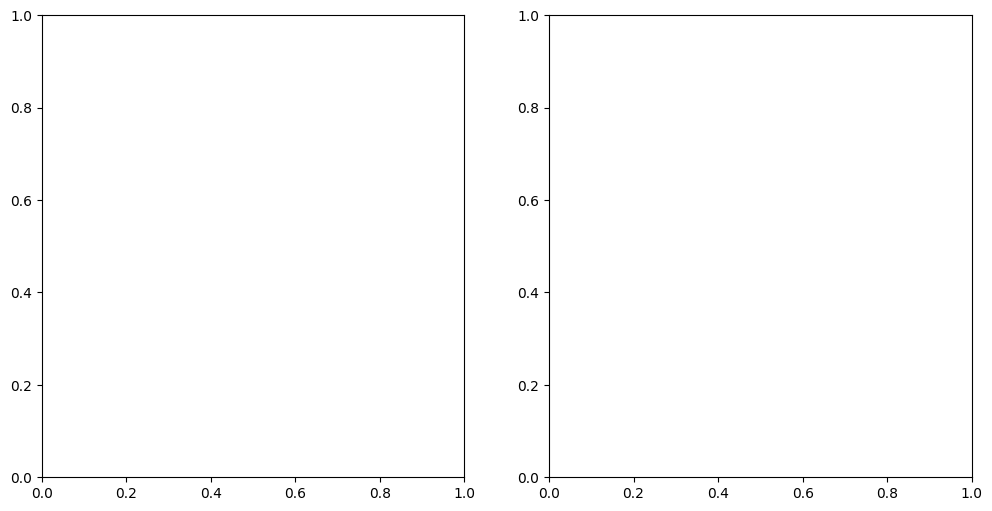

In [25]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
bins=np.linspace(0.,500.,100)
ax[0].hist([met_VH,met_WWW,met_bkg],bins=bins,
        weights=[np.full(met_VH.shape,weight_sig),
                 np.full(met_WWW.shape,weight_sig),
                 np.full(met_bkg.shape,weight_bkg)],
        histtype='bar', stacked=True,label=["VH","WWW","bkg"])
ax[0].set_yscale('log')
ax[0].text(0.55,0.95,"${\\cal L}=%3.0f$/fb"%lumi,transform=ax[0].transAxes)
ax[0].set_xlabel("MET [GeV]")
ax[0].set_ylabel("Entries")
ax[0].legend()

bins=np.linspace(0.,4.,80)
ax[1].hist([dr_VH,dr_WWW,dr_bkg],bins=bins,
        weights=[np.full(dr_VH.shape,weight_sig),
                 np.full(dr_WWW.shape,weight_sig),
                 np.full(dr_bkg.shape,weight_bkg)],
        histtype='step', stacked=False,density=True,label=["VH","WWW","bkg"])
ax[1].set_yscale('log')
ax[1].text(0.55,0.95,"${\\cal L}=%3.0f$/fb"%lumi,transform=ax[1].transAxes)
ax[1].set_xlabel("min($\\Delta R_{\\ell\\ell})$")
ax[1].set_ylabel("1/N dN/d min($\\Delta R_{\\ell\\ell})$")
ax[1].legend()